# Final project
In this project we will calibrate, rectify, object-track and classify
We will use stereo video data taken from learn

First problem:
    - Calibration
    
    - Calibration has to be done on a stereo plane. Both right and left images has to be used

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [3]:
"""
Implement the number of vertical and horizontal corners
nb_vertical = 6
nb_horizontal = 8
"""
nb_vertical = 9
nb_horizontal = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints_left = [] # 3d point in real world space
imgpoints_left = [] # 2d points in image plane.
objpoints_right = [] # 3d point in real world space
imgpoints_right = [] # 2d points in image plane.

images_left = glob.glob('../../Stereo_calibration_images/left*.png')
images_right = glob.glob('../../Stereo_calibration_images/right*.png')

assert images_left
assert images_right

for frame1, frame2 in zip(images_right, images_left):
    img_left = cv2.imread(frame2)
    gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    img_right = cv2.imread(frame1)
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    """
    Implement findChessboardCorners here
    """
    ret_left, corners_left = cv2.findChessboardCorners(img_left,(nb_vertical,nb_horizontal))
    ret_right, corners_right = cv2.findChessboardCorners(img_right,(nb_vertical,nb_horizontal))
    # If found, add object points, image points (after refining them)
    if ret_left == True:
        objpoints_left.append(objp)
        objpoints_right.append(objp)

        imgpoints_left.append(corners_left)
        imgpoints_right.append(corners_right)

        # Draw and display the corners
        img_left = cv2.drawChessboardCorners(img_left, (nb_vertical,nb_horizontal), corners_left,ret_left)
        img_right = cv2.drawChessboardCorners(img_right, (nb_vertical,nb_horizontal), corners_right,ret_right)
        #cv2.imshow('img',img)
        #cv2.imshow('img',img_left)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

Now let's try it on an image and see if it's undistorted

Text(0.5, 1.0, 'Undistorted image for left image')

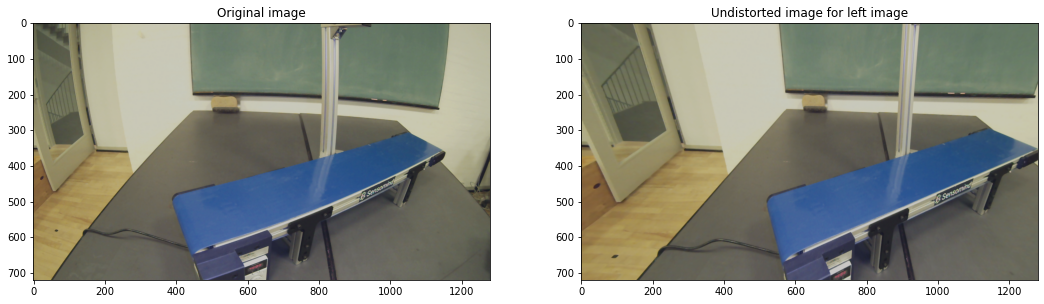

In [4]:
ret_left, mtx_left, dist_left, rvecs_left, tvecs_left = cv2.calibrateCamera(objpoints_left, imgpoints_left, gray_left.shape[::-1], None, None)
img_left = cv2.imread('../../Stereo_conveyor_without_occlusions/left/1585434279_805531979_Left.png')
h_left,  w_left = img_left.shape[:2]
w_left1,h_left1 = w_left,h_left
newcameramtx_left, roi_left = cv2.getOptimalNewCameraMatrix(mtx_left,dist_left,(w_left,h_left),0)

# undistort
dst_left = cv2.undistort(img_left, mtx_left, dist_left, None, newcameramtx_left)

fig_left, ax_left = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax_left[0].imshow(img_left[...,[2,1,0]])
ax_left[0].set_title('Original image')
ax_left[1].imshow(dst_left[...,[2,1,0]])
ax_left[1].set_title('Undistorted image for left image')

Text(0.5, 1.0, 'Undistorted image for right image')

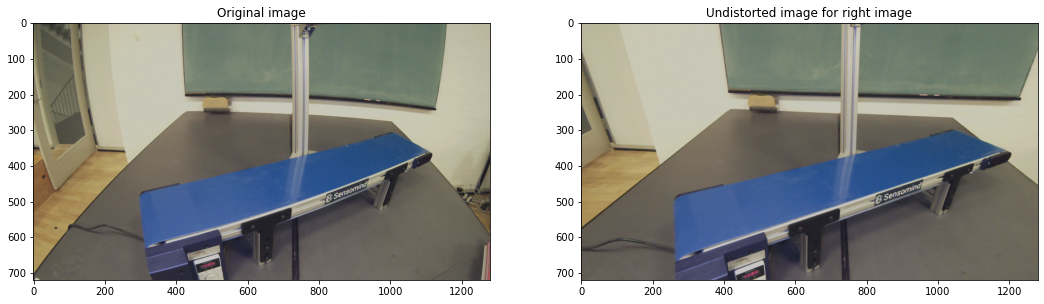

In [6]:
ret_right, mtx_right, dist_right, rvecs_right, tvecs_right = cv2.calibrateCamera(objpoints_right, imgpoints_right, gray_right.shape[::-1], None, None)
img_right = cv2.imread('../../Stereo_conveyor_without_occlusions/right/1585434279_805531979_Right.png')
h_right,  w_right = img_right.shape[:2]
newcameramtx_right, roi_right = cv2.getOptimalNewCameraMatrix(mtx_right,dist_right,(w_right,h_right),0)

# undistort
dst_right = cv2.undistort(img_right, mtx_right, dist_right, None, newcameramtx_right)

fig_right, ax_right = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax_right[0].imshow(img_right[...,[2,1,0]])
ax_right[0].set_title('Original image')
ax_right[1].imshow(dst_right[...,[2,1,0]])
ax_right[1].set_title('Undistorted image for right image')

Second problem: 
- Rectification


In [2]:
stereocalibration_flags = cv2.CALIB_FIX_INTRINSIC
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
images_right = glob.glob('../../Stereo_conveyor_without_occlusions/right/*.png')
images_left = glob.glob('../../Stereo_conveyor_without_occlusions/left/*.png')
assert images_right
assert images_left


i = 0
for frame1, frame2 in zip(images_right, images_left):
    img_right = cv2.imread(frame1)
    img_left = cv2.imread(frame2)
    
    if i == 0:
        width = img_right.shape[1]
        height = img_right.shape[0]
        ret_left, mtx_left, dist_left, rvecs_left, tvecs_left = cv2.calibrateCamera(objpoints_left, imgpoints_left, gray_left.shape[::-1], None, None)
        ret_right, mtx_right, dist_right, rvecs_right, tvecs_right = cv2.calibrateCamera(objpoints_right, imgpoints_right, gray_right.shape[::-1], None, None)
        newcameramtx_right, roi_right = cv2.getOptimalNewCameraMatrix(mtx_right,dist_right,(w_right,h_right),0)
        newcameramtx_left, roi_left = cv2.getOptimalNewCameraMatrix(mtx_left,dist_left,(w_left,h_left),0)
        ret, CM1, dist1, CM2, dist2, R, T, E, F = cv2.stereoCalibrate(objpoints_left, imgpoints_left, imgpoints_right, mtx_left, dist_left,
            mtx_right, dist_right, (width, height), criteria = criteria, flags = stereocalibration_flags)
        R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(mtx_left, dist_left, mtx_right, dist_right, (width, height), R, T)
        map1x, map1y = cv2.initUndistortRectifyMap(mtx_left, dist_left, R1, mtx_left, (width, height), cv2.CV_32FC1)
        map2x, map2y = cv2.initUndistortRectifyMap(mtx_right, dist_right, R1, mtx_right, (width, height), cv2.CV_32FC1)
        h_right,  w_right = img_right.shape[:2]
        h_left,  w_left = img_left.shape[:2]
    
    

    # undistort
    img_right = cv2.undistort(img_right, mtx_right, dist_right, None, newcameramtx_right)  

    #left image undistortion
    
    
    # undistort
    img_left = cv2.undistort(img_left, mtx_left, dist_left, None, newcameramtx_left)
    

    inter=cv2.INTER_LANCZOS4
    out_left = cv2.remap(img_left, map1x, map1y, inter)
    out_right = cv2.remap(img_right, map2x, map2y, inter)
    cv2.imwrite('../../rectified_images/left/'+str(i) + ".png", out_left)
    cv2.imwrite('../../rectified_images/right/'+str(i) + ".png", out_right)
    i+=1


NameError: name 'objpoints_left' is not defined